In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
#gradio imports below
import gradio as gr
from PIL import Image


In [24]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:

# Transformations 
transform = Compose([Resize((28, 28)), ToTensor()])

# Load the dataset
train_data = ImageFolder(root='trees', transform=transform) 
val_data = ImageFolder(root='trees-test-set', transform=transform) 
print('Classes:', train_data.classes) #ensure that we got the correct classes
# Create data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Classes: ['kataja', 'koivu', 'kuusi', 'manty', 'pihlaja', 'vaahtera']
Number of training samples: 160
Number of validation samples: 35


In [5]:
# in this part of code we check the number of files
import os
val_dir = 'trees-test-set' 
for root, dirs, files in os.walk(val_dir):
    print(f"Directory: {root}")
    print(f"Number of files: {len(files)}")
    print(f"Files: {files}")
    print("-" * 50)

Directory: trees-test-set
Number of files: 0
Files: []
--------------------------------------------------
Directory: trees-test-set\birch
Number of files: 11
Files: ['testbirch_01.jpg', 'testbirch_02.jpg', 'testbirch_03.jpg', 'testbirch_04.jpg', 'testbirch_05.jpg', 'testbirch_06.jpg', 'testbirch_07.jpg', 'testbirch_08.png', 'testbirch_09.jpeg', 'testbirch_10.jpeg', 'testbirch_11.png']
--------------------------------------------------
Directory: trees-test-set\juniper
Number of files: 12
Files: ['testjuniper_01.jpg', 'testjuniper_02.jpg', 'testjuniper_03.jpg', 'testjuniper_04.jpg', 'testjuniper_05.jpg', 'testjuniper_06.jpg', 'testjuniper_07.jpg', 'testjuniper_08.jpg', 'testjuniper_09.jpg', 'testjuniper_10.jpg', 'testjuniper_11.jpg', 'testjuniper_12.jpg']
--------------------------------------------------
Directory: trees-test-set\maple
Number of files: 11
Files: ['testmaple_01.jpg', 'testmaple_02.jpg', 'testmaple_03.jpg', 'testmaple_04.jpg', 'testmaple_05.jpg', 'testmaple_06.jpg', 'tes

In [6]:

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

In [7]:
%pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [8]:

# check the model architecture

from torchsummary import summary

# Display model summary 
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
# Print model architecture in a different format
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:

# Modify the final fully connected layer for transfer learning
model.fc = nn.Linear(512, 6).to(device) 

In [11]:


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training loop
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total

    # Log the metrics to W&B
    #wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_accuracy})
    print(f"Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%")

# Validation loop
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total
    # Log the metrics to W&B
   # wandb.log({"Validation Loss": epoch_loss, "Validation Accuracy": epoch_accuracy})

    print(f"Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}%")





In [13]:
# Train the model for 10 epochs (you can increase the epochs as needed like 50)
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train(model, train_loader, criterion, optimizer, device)
    validate(model, val_loader, criterion, device)

# Save the model to W&B
#wandb.watch(model)

Epoch 1/10
Train Loss: 1.832632475429111, Train Accuracy: 34.61538461538461%
Validation Loss: 1.692744642496109, Validation Accuracy: 35.0%
Epoch 2/10
Train Loss: 1.3676986628108554, Train Accuracy: 59.23076923076923%
Validation Loss: 1.376982506364584, Validation Accuracy: 55.0%
Epoch 3/10
Train Loss: 0.8837458822462294, Train Accuracy: 67.6923076923077%
Validation Loss: 0.837582990527153, Validation Accuracy: 78.33333333333333%
Epoch 4/10
Train Loss: 1.0105091863208346, Train Accuracy: 72.3076923076923%
Validation Loss: 0.9188056886196136, Validation Accuracy: 68.33333333333333%
Epoch 5/10
Train Loss: 1.0118648608525593, Train Accuracy: 78.46153846153847%
Validation Loss: 0.5875421799719334, Validation Accuracy: 85.0%
Epoch 6/10
Train Loss: 0.8173292436533504, Train Accuracy: 85.38461538461539%
Validation Loss: 0.5342604350298643, Validation Accuracy: 81.66666666666667%
Epoch 7/10
Train Loss: 0.876568529340956, Train Accuracy: 79.23076923076923%
Validation Loss: 0.7027161028236151, V

In [3]:
from PIL import Image
import torch

# Function to perform inference on a single image
def infer(model, image_path, transform, device):
    # Load the image and convert it to RGB (3 channels)
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  

    # Put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
    
    return predicted.item()

# Class names are based on the order printed from train_data.classes
class_names = ['kataja', 'koivu', 'kuusi', 'manty', 'pihlaja', 'vaahtera']

# Path to the test image
image_path = 'trees-test-set/koivu/testkoivu_001.jpg'  

# Run inference
predicted_class = infer(model, image_path, transform, device)
print(f'Predicted class: {class_names[predicted_class]}')





NameError: name 'model' is not defined

In [ ]:


%pip install scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


Number of predictions: 60
Number of true labels: 60


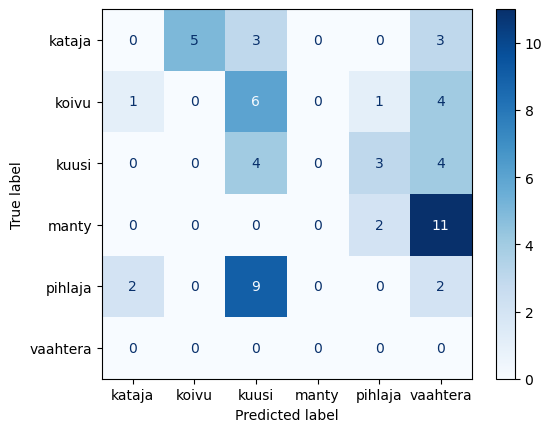

In [33]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions for the entire validation set
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert list of arrays to single numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# Get predictions and true labels from validation data
preds, labels = get_all_predictions(model, val_loader, device)
# Print the shape of preds and labels
print(f"Number of predictions: {len(preds)}")
print(f"Number of true labels: {len(labels)}")
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Display the confusion matrix
class_names = ['kataja', 'koivu', 'kuusi', 'manty', 'pihlaja', 'vaahtera']  # Based on your dataset # classit samaan järjestykseen kuin muualla!! 

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues) #Kuva tästä pakollinen palautukseen
plt.show()

#Open koodista transfer and learning osa 10. ei oo pakollinen


In [15]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [16]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
def predict(image):
    # Apply the same transformations as during training
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = train_data.classes[predicted.item()]
    return predicted_class

In [20]:
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Tree Species Classifier",
    description="Upload an image of a tree, and the model will predict its species."
)

c:\Users\nitta\anaconda3\envs\SolutionsInPR\Lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.1, however version 5.0.1 is available, please upgrade. 
--------
  warnings.warn(


In [21]:
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://aeb5ed2a274bdd7e62.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "c:\Users\nitta\anaconda3\envs\SolutionsInPR\Lib\site-packages\gradio\queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nitta\anaconda3\envs\SolutionsInPR\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nitta\anaconda3\envs\SolutionsInPR\Lib\site-packages\gradio\blocks.py", line 1935, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nitta\anaconda3\envs\SolutionsInPR\Lib\site-packages\gradio\blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nitta\anaconda3\envs\SolutionsInPR\Lib\site-packages\anyio\to_thr